## Import all the libraries that will be used

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

## Load the dataset

In [ ]:
data= pd.read_csv('creditscoring.csv')
data.head(3)

,duration,history,purpose,amount,savings,employed,installp,marital,coapp,resident,property,age,other,housing,existcr,job,depends,telephon,foreign,good_bad
0,6,4,3.0,1169,5,5,4,3,1,4,1,67,3,2,2,3,1,2,1,good
1,48,2,3.0,5951,1,3,2,2,1,2,1,22,3,2,1,3,1,1,1,bad
2,12,4,6.0,2096,1,4,2,3,1,3,1,49,3,2,1,2,2,1,1,good


## View the dimensions of the dataset

In [ ]:
data.shape

(1000, 20)

## Extracting the numerical features from the dataset

In [ ]:
numeric_features= data.select_dtypes(include= ['int64', 'float64'])

## Extracting the categorical features from the dataset

In [ ]:
categorical_features= data.select_dtypes(include= ['object'])

## Check if there are any missing values in the dataset

In [ ]:
for col in data:
    missing_values= data[col].isna().sum()
    if(missing_values>0):
        print('{} {}'.format(col, missing_values))

purpose 12


## Check the number of samples for each category in the target variable

In [ ]:
data['good_bad'].value_counts()

good    700
bad     300
Name: good_bad, dtype: int64

## Barplot to visualize the number of samples for each category in the target variable

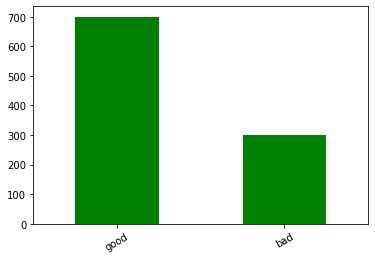

In [ ]:
data['good_bad'].value_counts().plot.bar( rot=30, color="green", width=0.5)

## Impute the missing values for the numerical feature using Iterative Imputer from Sci-kit learn

In [ ]:
impute_it = IterativeImputer()
numeric_features= impute_it.fit_transform(numeric_features)
numeric_features= pd.DataFrame(numeric_features)
numeric_features.columns= data.select_dtypes(include= ['int64', 'float64']).columns.tolist()

In [ ]:
data[numeric_features.columns]= numeric_features

In [ ]:
data.purpose.isna().sum()

0

## Dividing data into predictor variables (X) and target variable (y)

In [ ]:
X= data.drop('good_bad', axis=1)
print(X.shape)

y= data['good_bad']
print(y.shape)

# Label Encode the categories in target variable
y=y.map({'bad':0, 'good':1})

(1000, 19)
(1000,)


## Dividing dataset into train and test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20,random_state=0, stratify= y)

In [ ]:
X_train.shape, X_test.shape

((800, 19), (200, 19))

## Fit a XGBoost classifier

In [ ]:
clf_xgb= xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)

In [ ]:
clf_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Barplot to visualize the importance of features

In [ ]:
cols= X.columns.tolist()
importance_df = clf_xgb.feature_importances_
importance_df= pd.DataFrame(importance_df*100)
importance_df.index= cols
importance_df.columns= ['Importance']
importance_df= importance_df.sort_values('Importance', ascending= False)

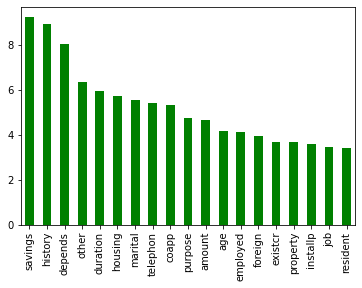

In [ ]:
importance_df['Importance'].plot.bar( rot=90, color="green", width=0.5)

## Making the predictions

In [ ]:
y_pred = clf_xgb.predict(X_test)

## Classification Report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54        60
           1       0.80      0.85      0.82       140

    accuracy                           0.74       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.74      0.74      0.74       200



## Confusion Matrix

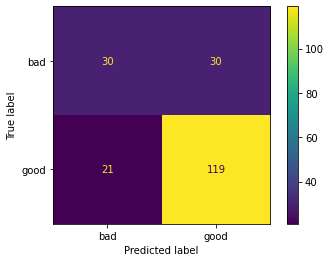

In [ ]:
plot_confusion_matrix(clf_xgb, X_test, y_test, 
values_format='d', display_labels=['bad', 'good'])

## Building a pipeline for hyperparameter tuning

In [ ]:
pipeline_XG_boost = Pipeline(steps=[
    ('XGBoost', clf_xgb)
])

param_grid_XG_boost= {
    'XGBoost__max_depth': [3,4,5],
    'XGBoost__learning_rate':[0.1,0.01,0.05],
    'XGBoost__gamma':[0, 0.25, 1],
    'XGBoost__reg_lambda':[0,1.0,10.0],
    'XGBoost__scale_pos_weight':[1,3,5]
}

## Performing Grid Search for hyperparameter tuning

In [ ]:
classifier_grid_search = GridSearchCV(pipeline_XG_boost, 
                        param_grid_XG_boost, cv=5,n_jobs=-1)

In [ ]:
classifier_grid_search.fit(X, y)

## Viewing the best hyperparameters

In [ ]:
print('Best max_depth:', classifier_grid_search.best_estimator_.get_params()['XGBoost__max_depth'])
print('Best learning_rate:', classifier_grid_search.best_estimator_.get_params()['XGBoost__learning_rate'])
print('Best gamma:', classifier_grid_search.best_estimator_.get_params()['XGBoost__gamma'])
print('Best reg_lambda:', classifier_grid_search.best_estimator_.get_params()['XGBoost__reg_lambda'])
print('Best scale_pos_weight:', classifier_grid_search.best_estimator_.get_params()['XGBoost__scale_pos_weight'])

Best max_depth: 4
Best learning_rate: 0.1
Best gamma: 1
Best reg_lambda: 0
Best scale_pos_weight: 3


## Plotting the ROC curve

In [ ]:
predicted_prob = classifier_grid_search.predict_proba(X_test)
predicted_prob= predicted_prob[:,1]
false_pos_rate, true_pos_rate, threshold = roc_curve(y_test, predicted_prob)

Text(0.5, 1.0, 'ROC curve for XG Boost')

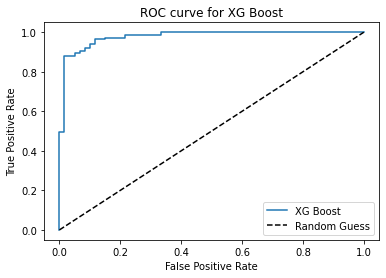

In [ ]:
plt.plot(false_pos_rate, true_pos_rate, label='XG Boost')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC curve for XG Boost")

## Plotting the PR curve

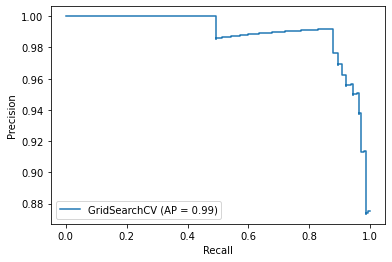

In [ ]:
disp = plot_precision_recall_curve(classifier_grid_search, X_test, y_test)